# 1. Introduction
In this notebook we prepare a movie database using data from the following two data source:
    
* [48.000+ movies](https://www.kaggle.com/datasets/yashgupta24/48000-movies-dataset) under [public domain license](https://creativecommons.org/publicdomain/zero/1.0/)
* [Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots) under [creative commons license](https://creativecommons.org/licenses/by-sa/4.0/)


# 2. Imports

In [184]:
# Installing weaviate vector database
#!pip install weaviate-client

In [185]:
# Importing libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import weaviate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [186]:
# Allows printout of full numpy array
np.set_printoptions(threshold=np.inf)

# 3. Loading Data

In [187]:
# Loading movie data
movie_data = pd.read_csv(
    filepath_or_buffer = "../data/movie_data.csv", 
    usecols = ['id', 'Name', 'PosterLink', 'Genres', 'Actors', 
               'Director','Description', 'DatePublished', 'Keywords'], 
    parse_dates = ["DatePublished"]
)

# Keeping only movies from >1970
movie_data["year"] = movie_data["DatePublished"].dt.year.fillna(0).astype(int)
movie_data.drop(["DatePublished"], axis=1, inplace=True)
movie_data = movie_data[movie_data.year > 1970]

In [188]:
# Loading movie plots
movie_plots = pd.read_csv('../data/movie_plots.csv')

# Keeping only movies from >1970
movie_plots = movie_plots[movie_plots['Release Year'] > 1970]
movie_plots = movie_plots[movie_plots.duplicated(subset=['Title', 'Release Year', 'Plot']) == False]
movie_plots = movie_plots[movie_plots.duplicated(subset=['Title', 'Release Year']) == False]
movie_plots = movie_plots[['Title', 'Plot', 'Release Year']]
movie_plots.columns = ['Name', 'Plot', 'year']

In [189]:
# Joining data
data = movie_data.merge(movie_plots, on=['Name', 'year'], how='left').fillna('')
data.reset_index(drop=True, inplace=True)

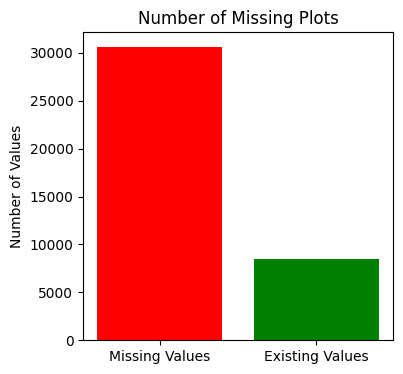

In [190]:
# Count missing and non-missing values in the "Plot" column
missing_values = (data['Plot'] == '').sum()
existing_values = (data['Plot'] != '').sum()

# Plot the number of missing and existing values for the "Plot" column
plt.figure(figsize=(4, 4))
plt.bar(['Missing Values', 'Existing Values'], [missing_values, existing_values], color=['red', 'green'])

# Add labels and title
plt.title('Number of Missing Plots')
plt.ylabel('Number of Values')

# Show the plot
plt.show()

# 4. Embeddings
Embeddings are can used to calculated the similarity between texts. Embeddings are vector representations of texts, and these can be made in [numerous ways](https://lena-voita.github.io/nlp_course/word_embeddings.html). The most common types of embeddings used to be based on normalized word counts, but today it is possible to make much more fancy contextual embeddings. These fancy embedding make it possible to differentiate e.g. between the word **lost** is these two sentences "I have **lost** my keys" and "I feel **lost**".

Here we will use [ChatGPT's fancy embeddings](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings). Access to these requires a payed subscription to OpenAI, such that an [API key](https://platform.openai.com/docs/api-reference/introduction) can be acquired.

As ChatGPT has a waiting list, we will start out by using a simple count vectorizer, that can be replaced later.

In [191]:
# Combining texts
data['text'] = data['Description'] + data['Plot']

## 4.1 Simple Embeddings

In [192]:
# Creating a TfidfVectorizer instance
vectorizer = TfidfVectorizer(max_features=30)

In [193]:
# Fitting and transforming the text data
X = vectorizer.fit_transform(data['text'])

In [194]:
# Checking out the first vector
a = X[100].toarray();type(a)
print(a) 

[[0.         0.         0.18029177 0.         0.         0.
  0.         0.38922591 0.         0.40183148 0.         0.
  0.         0.         0.         0.         0.17900529 0.1933632
  0.25460339 0.         0.         0.1790236  0.         0.
  0.         0.44085133 0.54210246 0.         0.         0.        ]]


In [195]:
# Adding embeddings to Dataframe
dense_array = X.toarray()
data['vector'] = pd.DataFrame({"vector": list(dense_array)})

# 5. Vector Database
We will here store the vectors in a vector database, which is efficient for several vector operations such as lookups and finding similar vectors. We are going to use the open-source database [Weaviate](https://weaviate.io/).

In [196]:
# Starting Weaviate docker container in background
!cd ../ && docker-compose up -d

Recreating moviesearch-weaviate-1 ... 
eating moviesearch-weaviate-1 ... done

In [197]:
# Setting up client
client = weaviate.Client(url="http://localhost:8080")

## 5.1 Adding Data to Database
Here we use our [custom vectors](https://weaviate.io/developers/weaviate/tutorials/custom-vectors), but it is also possible to just let weaviate created the vectors for one using an [external vectorizers](https://weaviate.io/developers/weaviate/modules/retriever-vectorizer-modules) as OpenAI or Huggingface.

In [198]:
# Defining a data collection
movie_class_schema = {
    "class": "Movies",
    "description": "A collection of movies since 1970.",
    "vectorIndexConfig": {"distance" : "cosine"},
}

In [199]:
# Defining schemas for columns, and which to vectorize
movie_class_schema["properties"] = [
        {
            "name": "movie_id",
            "dataType": ["number"],
            "description": "The id of the movie",        
        },
        {
            "name": "title",
            "dataType": ["text"],
            "description": "The name of the movie",   
        },
        {
            "name": "year",
            "dataType": ["number"],
            "description": "The year in which movie was published",   
        },
        {
            "name": "poster_link",
            "dataType": ["text"],
            "description": "The poster link of the movie",  
        },
        {
            "name": "genres",
            "dataType": ["text"],
            "description": "The genres of the movie",
        },
        {
            "name": "actors",
            "dataType": ["text"],
            "description": "The actors of the movie",  
        },
        {
            "name": "director",
            "dataType": ["text"],
            "description": "Director of the movie",
        },
        {
            "name": "description",
            "dataType": ["text"],
            "description": "overview of the movie",
            "vectorize": True
        },
        {
            "name": "Plot",
            "dataType": ["text"],
            "description": "Plot of the movie from Wikipedia",
            "vectorize": True
        },
        {
            "name": "keywords",
            "dataType": ["text"],
            "description": "main keywords of the movie", 
        },
]

In [200]:
# Deleting class if exists
current_schemas = client.schema.get()['classes']
for schema in current_schemas:
    if schema['class']=='Movies':
        client.schema.delete_class('Movies')
        
# Creating class
client.schema.create_class(movie_class_schema)

In [201]:
# Configure batch process - for faster imports 
client.batch.configure(
  batch_size=10, 
  dynamic=True,   # dynamically update the `batch_size` based on import speed
  timeout_retries=3,
)

In [202]:
# Importing the data
for i in tqdm(range(len(data))):
    item = data.iloc[i]

    movie_object = {
        'movie_id':float(item['id']),
        'title': str(item['Name']).lower(),
        'year': int(item['year']),
        'poster_link': str(item['PosterLink']),
        'genres':str(item['Genres']),
        'actors': str(item['Actors']).lower(),
        'director': str(item['Director']).lower(),
        'description':str(item['Description']),
        'plot': str(item['Plot']),
        'keywords': str(item['Keywords']),
    }

    try:
        client.batch.add_data_object(movie_object, "Movies", vector=item["vector"])
    except BaseException as error:
        print("Import Failed at: ",i)
        print("An exception occurred: {}".format(error))
        # Stop the import on error
        break

print(client.query.aggregate("Movies").with_meta_count().do())
client.batch.flush()

100%|████████████████████████████████████████████████████████████████████████| 39115/39115 [00:33<00:00, 1168.83it/s]


{'data': {'Aggregate': {'Movies': [{'meta': {'count': 37235}}]}}}


## 5.2 Making Example Lookups

In [203]:
# Just listing some rows
response = (
    client.query
    .get("Movies", ["movie_id", "title", "plot"])
    .with_additional("vector")
    .with_limit(2)
    .do()
)

print(json.dumps(response, sort_keys=True, indent=4))

{
    "data": {
        "Get": {
            "Movies": [
                {
                    "_additional": {
                        "vector": [
                            0,
                            0.065487824,
                            0.14579736,
                            0,
                            0.25726745,
                            0.037869398,
                            0.07743622,
                            0.034973007,
                            0.06796947,
                            0.10831695,
                            0.11728534,
                            0.07042402,
                            0,
                            0,
                            0.030502146,
                            0.17687982,
                            0.048252337,
                            0.01737421,
                            0.25164488,
                            0.06692125,
                            0,
                            0.016085757,
           

In [204]:
# Looking up a movie
response = (
    client.query
    .get("Movies", ["title"])
    .with_bm25(
      query="Blade"
    )
    .with_limit(5)
    .do()
)

print(json.dumps(response, sort_keys=True, indent=4))

{
    "data": {
        "Get": {
            "Movies": [
                {
                    "title": "hitman hart: wrestling with shadows"
                },
                {
                    "title": "blade: trinity"
                },
                {
                    "title": "freaky friday"
                },
                {
                    "title": "meadowland"
                },
                {
                    "title": "blade ii"
                }
            ]
        }
    }
}
